In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from functions import *



In [2]:
haplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_haplotypes.parquet')

In [3]:
def barplot_frequency(data, x_col, y_col, xlabel, ylabel, title, figsize=(30, 15), fontsize=15, label_fontsize=30, title_fontsize=None, x_ticks_rotation=True, ylim=None, legend=None, color='#ADD8E6', ci=None, colored_xticks=False, color_col=None, hue=None, palette='Set2', grid=False):
    plt.figure(figsize=figsize)
    chart = sns.barplot(x=x_col, y=y_col, data=data, color=color, ci=ci, hue=hue, palette=palette, edgecolor='black')

    for p in chart.patches:
        chart.annotate("{:,.2f}".format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=fontsize)

    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    if grid:
        plt.grid(alpha=0.2)

    if title_fontsize is not None:
        plt.title(title, fontsize=title_fontsize, loc='center', pad=20)
    else:
        plt.title(title, fontsize=30, loc='center', pad=20)

    if x_ticks_rotation:
        plt.xticks(rotation=45, fontsize=15)
        plt.yticks(fontsize=15)
    else:
        plt.xticks(fontsize=10, weight='semibold')
        plt.yticks(fontsize=10, weight='semibold')

    if ylim is not None:
        plt.ylim(0, ylim)

    if colored_xticks and color_col:
        unique_values = data[color_col].unique()
        color_palette = ['green', 'blue', 'tomato', 'yellow', 'brown', 'black'] #sns.color_palette("Paired", len(unique_values))
        color_map = dict(zip(unique_values, color_palette))

        for i, tick in enumerate(chart.get_xticklabels()):
            tick.set_color(color_map[data[color_col].iloc[i]])

    if legend is not None and hue:
        hue_legend = plt.legend(title=legend, fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1, loc='best', bbox_to_anchor=(0.82, 1))

    if legend is not None and colored_xticks and color_col:
        patch_list = []
        for key, value in color_map.items():
            patch_list.append(mpatches.Patch(color=value, label=key))
        xtick_legend = plt.legend(handles=patch_list, title="Function", loc=1, fontsize=15, fancybox=True, framealpha=1, shadow=True, borderpad=1)
        plt.gca().add_artist(hue_legend)
        plt.show()
        
    plt.tight_layout()
    plt.show()




In [4]:
haplotype_df

,haplotype,AC,AF,AC_C,AF_C,AF_GA_C,AC_I,AF_I,AF_GA_I,AC_M,AF_M,AF_GA_M,activity_value,function
0,*10+*36,866,28.809049,776.0,25.815037,34.094903,10.0,0.332668,3.030303,80.0,2.661344,20.00,0.25,Decreased function
1,*1,833,27.711244,587.0,19.527611,25.790861,124.0,4.125083,37.575758,122.0,4.058550,30.50,1.00,Normal function
2,*10,529,17.598137,413.0,13.739188,18.145870,11.0,0.365935,3.333333,105.0,3.493014,26.25,0.25,Decreased function
3,*2,301,10.013307,197.0,6.553560,8.655536,66.0,2.195609,20.000000,38.0,1.264138,9.50,1.00,Normal function
4,*41,142,4.723886,85.0,2.827678,3.734622,40.0,1.330672,12.121212,17.0,0.565536,4.25,0.50,Decreased function
5,*5,104,3.459747,73.0,2.428476,3.207381,20.0,0.665336,6.060606,11.0,0.365935,2.75,0.00,No function
6,*36,47,1.563540,42.0,1.397206,1.845343,0.0,0.000000,0.000000,5.0,0.166334,1.25,0.00,No function
7,*14,33,1.097804,32.0,1.064538,1.405975,0.0,0.000000,0.000000,1.0,0.033267,0.25,0.50,Decreased function
8,*4,31,1.031271,2.0,0.066534,0.087873,21.0,0.698603,6.363636,8.0,0.266134,2.00,0.00,No function
9,*49,21,0.698603,20.0,0.665336,0.878735,0.0,0.000000,0.000000,1.0,0.033267,0.25,0.50,Decreased function


# 1. Haplotype Frequency Distribution 

/tmp/ipykernel_2657773/1190172909.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  chart = sns.barplot(x=x_col, y=y_col, data=data, color=color, ci=ci, hue=hue, palette=palette, edgecolor='black')


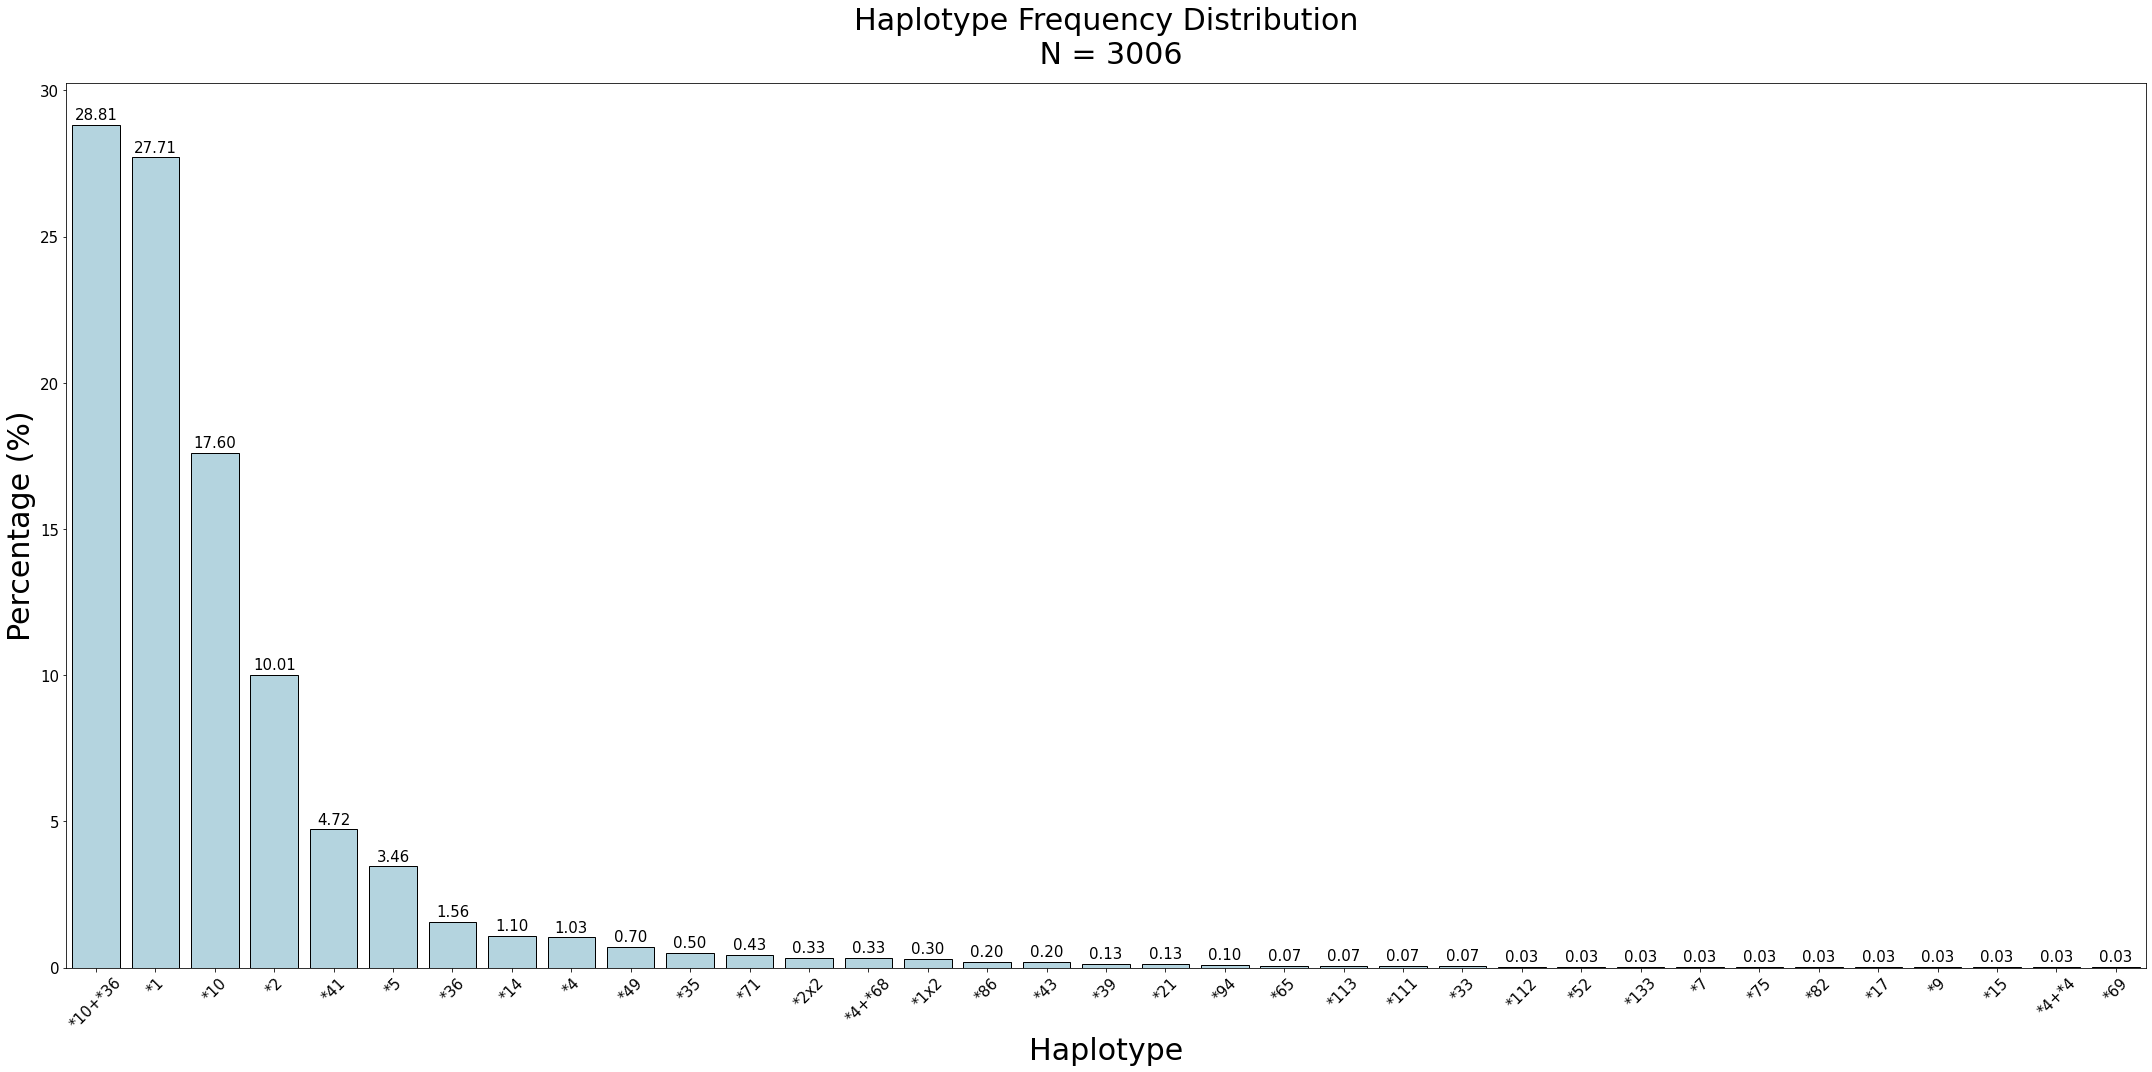

In [5]:
# Haplotype Frequency Distribution
barplot_frequency(haplotype_df, x_col='haplotype', y_col='AF', xlabel='Haplotype', ylabel='Percentage (%)', title=f"Haplotype Frequency Distribution\n N = {haplotype_df['AC'].sum()}", ci=None, color='#ADD8E6', palette=None)


# 2. Haplotype Frequency Distribution Amongst Genetic Ancestry

In [6]:
data = pd.melt(haplotype_df, id_vars=['haplotype', 'activity_value', 'function'], value_vars=['AF_GA_C', 'AF_GA_I', 'AF_GA_M'], var_name='genetic_ancestry', value_name='percentage')
data = data.replace({'AF_GA_C': 'Chinese', 'AF_GA_I': 'Indian', 'AF_GA_M': 'Malay'})
top_10_haplotypes = haplotype_df.sort_values(by='AF', ascending=False).head(10)['haplotype'].tolist()

/tmp/ipykernel_2657773/1190172909.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  chart = sns.barplot(x=x_col, y=y_col, data=data, color=color, ci=ci, hue=hue, palette=palette, edgecolor='black')


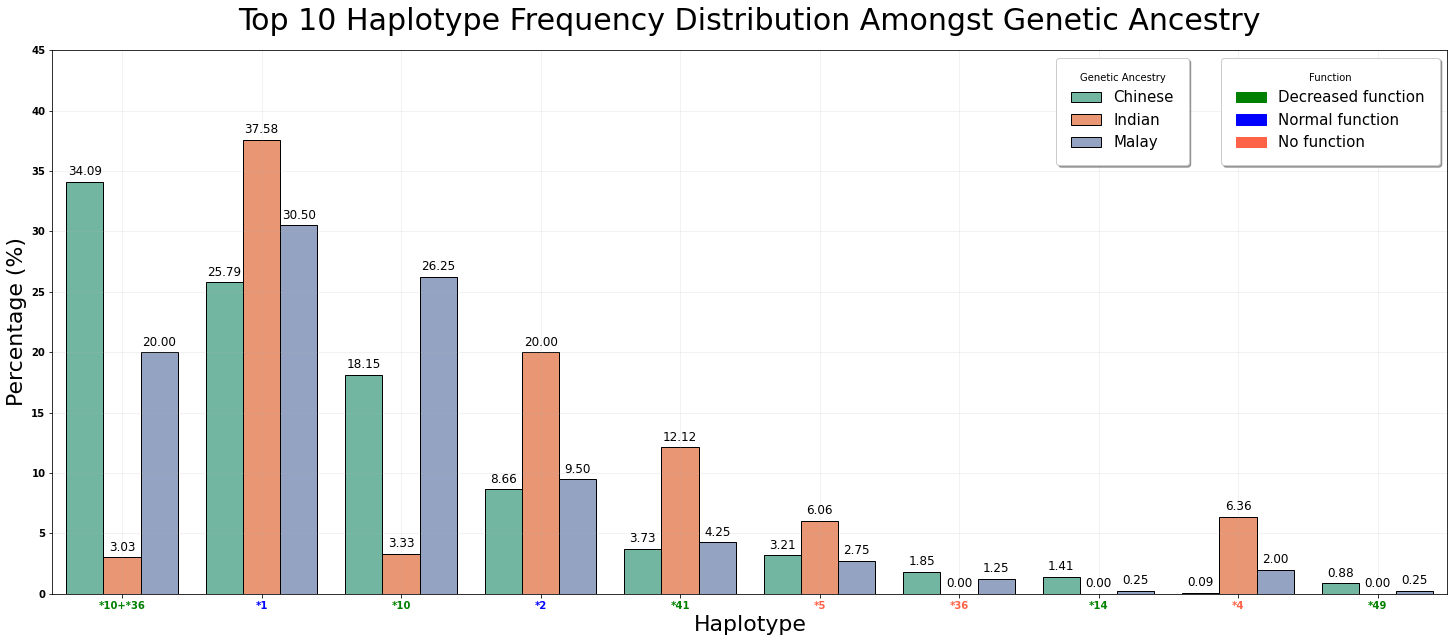

<Figure size 432x288 with 0 Axes>

In [7]:
barplot_frequency(data[data['haplotype'].isin(top_10_haplotypes)], 
                  x_col='haplotype', y_col='percentage', 
                  xlabel='Haplotype', ylabel='Percentage (%)', 
                  title='Top 10 Haplotype Frequency Distribution Amongst Genetic Ancestry', 
                  figsize=(25, 10), fontsize=12, label_fontsize=22,
                  x_ticks_rotation=False, ylim=45, legend='Genetic Ancestry', hue='genetic_ancestry', palette='Set2',
                  colored_xticks=True, color_col="function", grid = True)


In [8]:
haplotype_df.head()

,haplotype,AC,AF,AC_C,AF_C,AF_GA_C,AC_I,AF_I,AF_GA_I,AC_M,AF_M,AF_GA_M,activity_value,function
0,*10+*36,866,28.809049,776.0,25.815037,34.094903,10.0,0.332668,3.030303,80.0,2.661344,20.00,0.25,Decreased function
1,*1,833,27.711244,587.0,19.527611,25.790861,124.0,4.125083,37.575758,122.0,4.058550,30.50,1.00,Normal function
2,*10,529,17.598137,413.0,13.739188,18.145870,11.0,0.365935,3.333333,105.0,3.493014,26.25,0.25,Decreased function
3,*2,301,10.013307,197.0,6.553560,8.655536,66.0,2.195609,20.000000,38.0,1.264138,9.50,1.00,Normal function
4,*41,142,4.723886,85.0,2.827678,3.734622,40.0,1.330672,12.121212,17.0,0.565536,4.25,0.50,Decreased function


/tmp/ipykernel_2657773/1190172909.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  chart = sns.barplot(x=x_col, y=y_col, data=data, color=color, ci=ci, hue=hue, palette=palette, edgecolor='black')


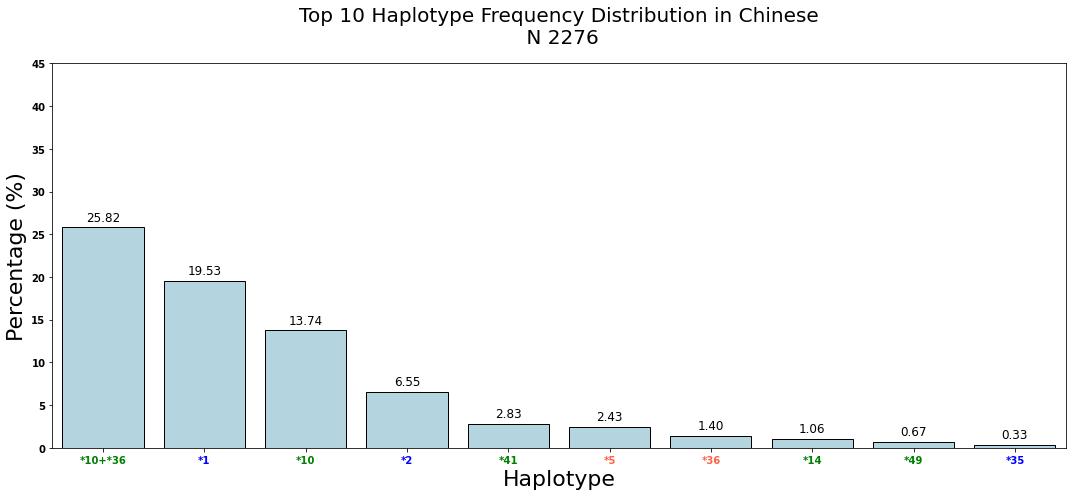

In [9]:
barplot_frequency(haplotype_df.sort_values('AF_C', ascending=False).head(10), 
                  x_col='haplotype', y_col='AF_C', 
                  xlabel='Haplotype', ylabel='Percentage (%)', 
                  title=f'Top 10 Haplotype Frequency Distribution in Chinese\n N {int(haplotype_df["AC_C"].sum())}', 
                  figsize=(15, 7), fontsize=12, label_fontsize=22,
                  x_ticks_rotation=False, ylim=45, palette=None,
                  colored_xticks=True, color_col="function", title_fontsize=20)
